In [1]:
!pip install deslib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 KB 4.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("ggplot")

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, make_scorer

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance as lgbimp
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from deslib.des.knora_u import KNORAU
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Preprocessing

## PassengerID and Ticket

PassengerID and ticket variables are not helpful in terms of predicting the test set. So I dropped both of them in the training set and dropped only the ticket variable in the test set since I had to use them during submission.

In [6]:
train.drop(["PassengerId","Ticket"], axis = 1, inplace = True)
test.drop("Ticket", axis = 1, inplace = True)

## Name

I thought surnames could be important while filling missing values and making predictions; therefore, I defined a surname_extractor function which takes the surnames and drops the rest of the name both in training and test set. 

Among the duplicated surnames, I assumed the ones having equal amount of survival and number of instances were survived and the ones having no survival were not able to survive. I recorded these instances so if there are instances with these surnames, I could label them directly.

In [7]:
def surname_extractor(data):
    data["Surname"] = [data["Name"].str.split(" ")[i][0][:-1] for i in range(len(data))]
    data.drop("Name", axis = 1, inplace = True)
    return data

In [8]:
train = surname_extractor(train)
dups = train.loc[train.Surname.duplicated()]

In [9]:
count_df = pd.DataFrame()
count_df["Surname"] = dups.Surname.unique()
ins = []
sur = []
for surname in count_df["Surname"]:
    number_of_instances = len(dups[dups.Surname == surname])
    ins.append(number_of_instances)
    total_survival = dups[dups.Surname == surname]["Survived"].sum()
    sur.append(total_survival)
    
count_df["number_of_instances"] = ins
count_df["total_survival"] = sur

count_df = count_df[count_df["number_of_instances"] != 1]
count_df.head()

,Surname,number_of_instances,total_survival
0,Palsson,3,0
1,Vande,4,0
2,Andersson,8,2
3,Goodwin,5,0
4,Fortune,3,2


In [10]:
not_survived = count_df[count_df["total_survival"] == 0]
not_survived_surnames = not_survived.Surname

survived = count_df[count_df["total_survival"] == count_df["number_of_instances"]]
survived_surnames = survived.Surname

In [11]:
test = surname_extractor(test)

## Sex

Sex is a binary categorical feature having no missing values. The only thing I did is encode them using LabelEncoder

In [12]:
le = LabelEncoder()
train.Sex = le.fit_transform(train.Sex)
test.Sex = le.transform(test.Sex)

## Pclass

Pclass has 3 unique variables and no missing values. There is a correlation between Pclass and survival rate. Therefore, I leave this variable as it is for now and see whether the ordinality helps the prediction. 

In [13]:
first_class_survival_rate = train[train.Pclass == 1]["Survived"].sum()/len(train[train.Pclass == 1])
second_class_survival_rate = train[train.Pclass == 2]["Survived"].sum()/len(train[train.Pclass == 2])
third_class_survival_rate = train[train.Pclass == 3]["Survived"].sum()/len(train[train.Pclass == 3])

print(f"First class survival rate: {first_class_survival_rate:.2f}")
print(f"Second class survival rate: {second_class_survival_rate:.2f}")
print(f"Third class survival rate: {third_class_survival_rate:.2f}")

First class survival rate: 0.63
Second class survival rate: 0.47
Third class survival rate: 0.24


 ## Age
 
 There are some missing values in this variable. From the graphs filling the missing values with median seems logical. There are some minor differences between genders and datasets so i filled the values accordingly.

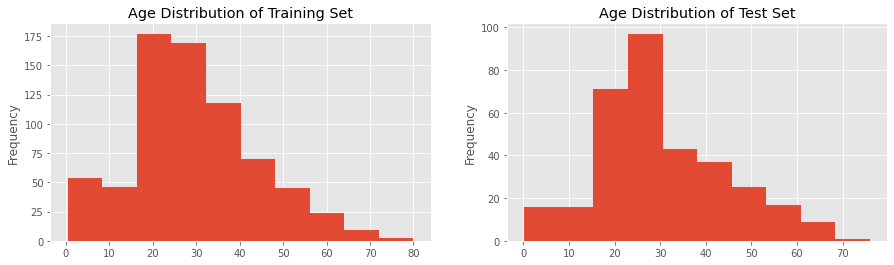

In [14]:
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
train.Age.plot.hist(title = "Age Distribution of Training Set", ax = axes[0])
test.Age.plot.hist(title = "Age Distribution of Test Set", ax = axes[1])
plt.show()

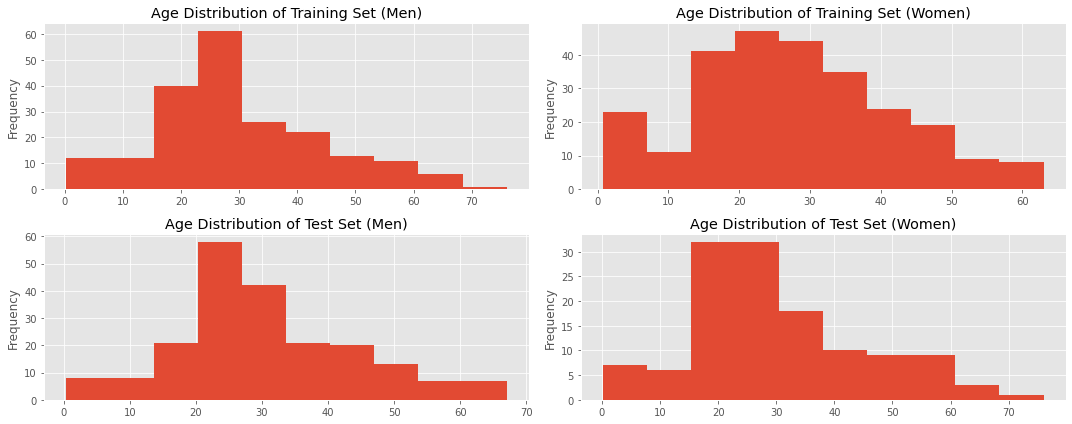

In [15]:
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,6))

test[train.Sex == 1].Age.plot.hist(title = "Age Distribution of Training Set (Men)", ax = axes[0][0])
train[train.Sex == 0].Age.plot.hist(title = "Age Distribution of Training Set (Women)", ax = axes[0][1])
test[test.Sex == 1].Age.plot.hist(title = "Age Distribution of Test Set (Men)", ax = axes[1][0])
test[test.Sex == 0].Age.plot.hist(title = "Age Distribution of Test Set (Women)", ax = axes[1][1])

plt.tight_layout()
plt.show()

In [16]:
train['Age'] = train['Age'].fillna(train.groupby('Sex')['Age'].transform('median'))
test['Age'] = test['Age'].fillna(test.groupby('Sex')['Age'].transform('median'))
print(f'Number of missing values(train): {train["Age"].isna().sum()}')
print(f'Number of missing values(train): {test["Age"].isna().sum()}')

Number of missing values(train): 0
Number of missing values(train): 0


## SibSp & Parch

I didn't find any relation between SibSp and Parch features with survival rate so I dropped them. 

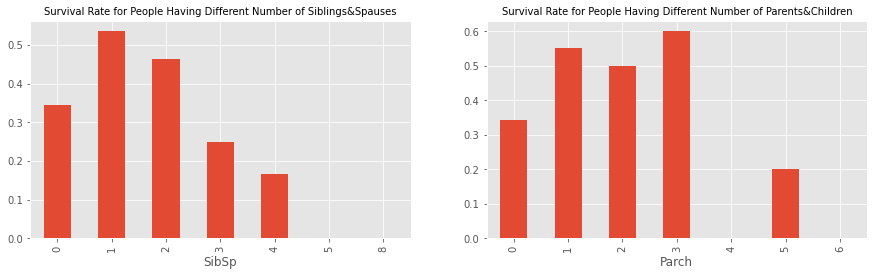

In [17]:
fig,axes = plt.subplots(ncols = 2,figsize = (15,4))
train.groupby("SibSp")["Survived"].mean().plot(kind = "bar", ax = axes[0])
train.groupby("Parch")["Survived"].mean().plot(kind = "bar", ax = axes[1])
axes[0].set_title("Survival Rate for People Having Different Number of Siblings&Spauses", fontsize = 10)
axes[1].set_title("Survival Rate for People Having Different Number of Parents&Children", fontsize = 10)
plt.show()

In [18]:
train.drop(["Parch","SibSp"], axis = 1, inplace = True)
test.drop(["Parch","SibSp"], axis = 1, inplace = True)

## Fare

Fare is a continuous feature. To draw a conclusion, I segmented them into 4 categories. People who paid fare starting from 384 dollars were completely survived. Therefore in test set, i could use to label the instances with same properties as 1(survived).

There is a strong correlation(0.55) between Fare and Pclass as expected. This can cause colinearity so while constructing the model I have to keep that in mind. 

In test set there is a missing value. Total fare is positively skewed therefore mean of the fare is slightly higher compared to the median. I filled the missing value with median because of the skew.

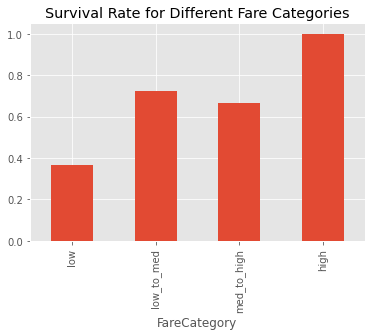

In [19]:
plot_df = pd.DataFrame()
plot_df["FareCategory"] = pd.cut(train.Fare,bins = 4,labels = ["low", "low_to_med", "med_to_high", "high"]).values
plot_df["Survival"] = train.Survived
plot_df.groupby("FareCategory")["Survival"].mean().plot(kind = "bar", title = "Survival Rate for Different Fare Categories")
plt.show()

In [20]:
print(f'Correlation between Fare and Pclass: {train.corr().loc["Pclass","Fare"]:.2f}')

Correlation between Fare and Pclass: -0.55


In [21]:
fares = []
fares.extend(train.Fare.values)
fares.extend(test.Fare[test.Fare.notnull()].values)
fares = np.array(fares)

Mean fare: 33.30
Median fare: 14.45


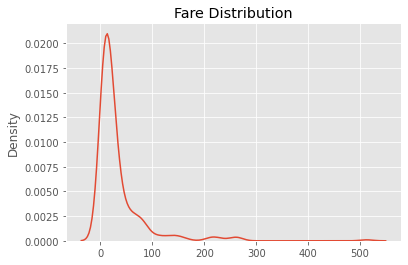

In [22]:
print(f"Mean fare: {fares.mean():.2f}")
print(f"Median fare: {np.median(fares):.2f}")
sns.kdeplot(x = fares)
plt.title("Fare Distribution")
test.Fare = test.Fare.fillna(np.median(fares))

## Cabin

Cabin predictor has lots of missing values and it is a high cardinality feature. I can encode this variable with useful encoding methods for high cardinality features but I think it has no direct relationship with survival rate. Even it has, probably it could be explained with other variables. So I drop this variable.

In [23]:
print(f"Number of unique variables: {train.Cabin.nunique()}")

Number of unique variables: 147


In [24]:
train.drop("Cabin", axis = 1, inplace = True)
test.drop("Cabin", axis = 1, inplace = True)

## Embarked

Embarked feature tells where do the people have embarked from. Cherbourg survival rate is bigger than Queenstown and it is bigger than Southampton. Since the number of instances are not same, probably the survival rate is not a reliable metric for inference. 

I expect that there is no correlation of this feature with survival rate but since it has low cardinality I will keep it and see whether it is actually important or not after training the model.

There are two missing values in training set and no missing values in test set. The surnames are not duplicated both train and test set so I can't fill them accordingly. The best thing to do is fill them with the most frequent one which is "S". 


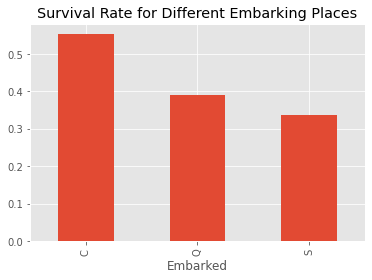

In [25]:
train.groupby("Embarked")["Survived"].mean().plot(kind = "bar", title = "Survival Rate for Different Embarking Places")
plt.show()

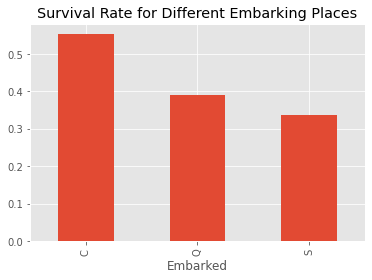

In [26]:
train.groupby("Embarked")["Survived"].mean().plot(kind = "bar", title = "Survival Rate for Different Embarking Places")
plt.show()

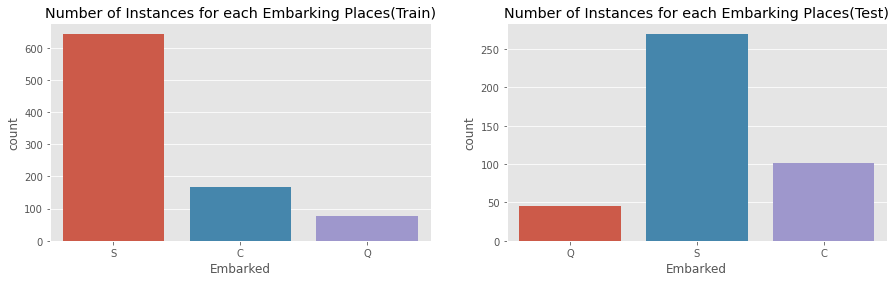

In [27]:
fig,axes = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(train.Embarked,ax = axes[0])
sns.countplot(test.Embarked,ax = axes[1])
axes[0].set_title("Number of Instances for each Embarking Places(Train)")
axes[1].set_title("Number of Instances for each Embarking Places(Test)")
plt.show()

In [28]:
train.Embarked = train.Embarked.fillna("S")

In [29]:
train = pd.get_dummies(train, columns = ["Embarked"])
test = pd.get_dummies(test, columns = ["Embarked"])

## Survival

There is an imbalance in target variable. While construcitng the model I have to keep that in mind.

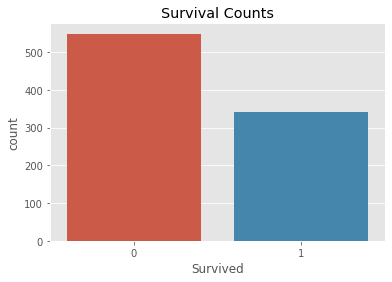

In [30]:
sns.countplot(train.Survived)
plt.title("Survival Counts")
plt.show()

# Model

## Finding Best Base Model

To select best base model, I considered 3 folded evaluation. There are 7 candidates for best model.
* XGB and LGBM were selected because they have been proved to be the most successful ml models (Boosting).
* LogisticRegression and SVM were selected because of they analyse the data with different approaches (Analytical).
* Dynamic Ensemble Trees and KNeighbors were selected to see the performance. (Similarity)


The models have similar performances therefore to get more out of them I used meta learner after tuning them.



In [31]:
X_train = train.drop(["Survived","Surname"], axis = 1)
y_train = train.Survived
IDs = test.PassengerId
X_test = test.drop(["PassengerId","Surname"], axis = 1)

pipe_log = make_pipeline(StandardScaler(),LogisticRegression(class_weight = "balanced"))
pipe_kn = make_pipeline(StandardScaler(),KNeighborsClassifier())
pipe_svm = make_pipeline(StandardScaler(),LinearSVC(class_weight="balanced"))
pipe_des = make_pipeline(StandardScaler(),KNORAU())

models = [
    XGBClassifier(learning_rate = 0.1, n_estimators = 100,use_label_encoder = False),
    LGBMClassifier(),
    pipe_log,
    pipe_kn,
    pipe_svm,
    pipe_des
]

for model in models:
    skf = StratifiedKFold(n_splits = 3,shuffle = True)
    acc = []
    for train_idx,test_idx in skf.split(X_train,y_train):
        X_train_cv = X_train.loc[train_idx]
        X_test_cv = X_train.loc[test_idx]
        y_train_cv = y_train.loc[train_idx]
        y_test_cv = y_train.loc[test_idx]

        model.fit(X_train_cv,y_train_cv)
        preds = model.predict(X_test_cv)
        acc.append(roc_auc_score(y_test_cv,preds))
    print(model.__class__.__name__,np.round(np.array(acc).mean(),2))


[09:44:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:44:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:44:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.8
LGBMClassifier 0.8
Pipeline 0.78
Pipeline 0.79
Pipeline 0.77
Pipeline 0.76


## Tuning the Models

**Parameters**

1. **Logistic:** 'C': 1, 'solver': 'liblinear'
2. **KNN:** 'n_neighbors': 7
3. **SVM:** C': 10, 'loss': 'squared_hinge'
4. **KNORAU:** 'k': 7 or 11 
5. **XGBoost:** 'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 200
6. **LGBM:** 'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 300

In [32]:
X_train_scaled = (X_train-X_train.mean())/X_train.std()

In [33]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"solver": ['liblinear','newton-cg','sag','saga','lbfgs'],
#                  "C": [1,5,10]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(LogisticRegression(class_weight="balanced"),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train_scaled,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [34]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"n_neighbors": [3,5,7]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(KNeighborsClassifier(),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train_scaled,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [35]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"loss":['squared_hinge',"hinge"],"C": [1,5,10]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(LinearSVC(class_weight="balanced"),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train_scaled,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [36]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"k": [3,5,7,9,11,13,15]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(KNORAU(),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train_scaled,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [37]:
#n_estimators & learning rate

#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"learning_rate": [0.1,0.01,0.05], "n_estimators": [100,200,300,400]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(XGBClassifier(),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train,y_train, eval_metric = "logloss")
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [38]:
# max_depth

#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"max_depth": [3,5,7]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(XGBClassifier(learning_rate = 0.01, n_estimators = 200),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train,y_train, eval_metric = "logloss")
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [39]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"learning_rate": [0.1,0.01,0.05], "n_estimators": [100,200,300,400]}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(LGBMClassifier(class_weight="balanced"),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

In [40]:
#for trial in range(5):
#    print(f"Trial: {trial+1}\n******")
#    grid_params = {"max_depth": [3,5,7],}
#    my_score = make_scorer(roc_auc_score)
#    grid = GridSearchCV(LGBMClassifier(class_weight="balanced",learning_rate = 0.01, n_estimators = 300),grid_params,cv = StratifiedKFold(n_splits = 3,shuffle = True),scoring = my_score)
#    grid.fit(X_train,y_train)
#    print(f"Best Parameters: {grid.best_params_}\n")
#    for param, score in zip(grid.cv_results_["params"],grid.cv_results_["mean_test_score"]):
#        print(param,np.round(score,3))

## Feature Selection

I ran at 3 different seeds for both XGB and LGBM. The decision of both models comes mostly from Fare (AUC score does not improve) yet I kept other features. In the final model they might improve the prediction.

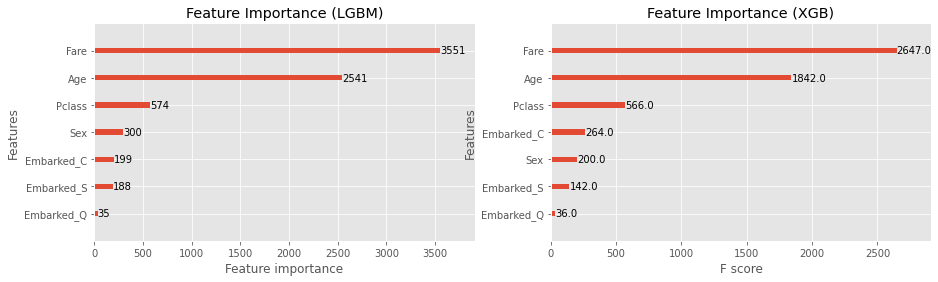

In [41]:
xgb = XGBClassifier(learning_rate = 0.01, n_estimators = 200,use_label_encoder = False)
xgb.fit(X_train,y_train,eval_metric = "logloss")
lgb = LGBMClassifier(class_weight='balanced',learning_rate = 0.01, n_estimators = 300,max_depth = 7)
lgb.fit(X_train,y_train)

fig, axes = plt.subplots(ncols = 2, figsize = (15,4))
lgbimp(lgb,ax = axes[0],title = "Feature Importance (LGBM)")
plot_importance(xgb,ax = axes[1],title = "Feature Importance (XGB)")
plt.show()

In [42]:
SEED = np.random.randint(low = 1, high = 100, size = 3)
for s in SEED:
    print("\nSeed: ",s)
    model = LGBMClassifier(class_weight='balanced',random_state = s)
    model.fit(X_train,y_train)
    thresholds = np.sort(model.feature_importances_)
    for thr in thresholds:
        select_features = SelectFromModel(model,threshold = thr, prefit = True)
        transformed_train = select_features.transform(X_train)
        skf = StratifiedKFold(n_splits = 3, random_state = s, shuffle = True)
        acc = []
        for train_idx,test_idx in skf.split(transformed_train,y_train):
            X_train_cv = X_train.loc[train_idx]
            X_test_cv = X_train.loc[test_idx]
            y_train_cv = y_train.loc[train_idx]
            y_test_cv = y_train.loc[test_idx]

            model.fit(X_train_cv,y_train_cv)
            preds = model.predict(X_test_cv)
            acc.append(roc_auc_score(y_test_cv,preds))
        print(f"LGBM Treshold: {thr} - AUC Score: {np.round(np.array(acc).mean(),2)}")



Seed:  16
LGBM Treshold: 23 - AUC Score: 0.8
LGBM Treshold: 51 - AUC Score: 0.8
LGBM Treshold: 82 - AUC Score: 0.8
LGBM Treshold: 96 - AUC Score: 0.8
LGBM Treshold: 129 - AUC Score: 0.8
LGBM Treshold: 1125 - AUC Score: 0.8
LGBM Treshold: 1494 - AUC Score: 0.8

Seed:  15
LGBM Treshold: 23 - AUC Score: 0.82
LGBM Treshold: 51 - AUC Score: 0.82
LGBM Treshold: 82 - AUC Score: 0.82
LGBM Treshold: 96 - AUC Score: 0.82
LGBM Treshold: 129 - AUC Score: 0.82
LGBM Treshold: 1125 - AUC Score: 0.82
LGBM Treshold: 1494 - AUC Score: 0.82

Seed:  46
LGBM Treshold: 23 - AUC Score: 0.81
LGBM Treshold: 51 - AUC Score: 0.81
LGBM Treshold: 82 - AUC Score: 0.81
LGBM Treshold: 96 - AUC Score: 0.81
LGBM Treshold: 129 - AUC Score: 0.81
LGBM Treshold: 1125 - AUC Score: 0.81
LGBM Treshold: 1494 - AUC Score: 0.81


In [43]:
SEED = np.random.randint(low = 1, high = 100, size = 3)
for s in SEED:
    print("\nSeed: ",s)
    model = XGBClassifier(random_state = 42, eval_metric = "logloss")
    model.fit(X_train,y_train)
    thresholds = np.sort(model.feature_importances_)
    for thr in thresholds:
        select_features = SelectFromModel(model,threshold = thr, prefit = True)
        transformed_train = select_features.transform(X_train)
        skf = StratifiedKFold(n_splits = 3,shuffle = True,random_state = 42)
        acc = []
        for train_idx,test_idx in skf.split(transformed_train,y_train):
            X_train_cv = X_train.loc[train_idx]
            X_test_cv = X_train.loc[test_idx]
            y_train_cv = y_train.loc[train_idx]
            y_test_cv = y_train.loc[test_idx]

            model.fit(X_train_cv,y_train_cv,eval_metric = "error")
            preds = model.predict(X_test_cv)
            acc.append(roc_auc_score(y_test_cv,preds))
        print(f"Treshold: {thr} - AUC Score: {np.round(np.array(acc).mean(),2)}")


Seed:  78
Treshold: 0.013003438711166382 - AUC Score: 0.8
Treshold: 0.028630167245864868 - AUC Score: 0.8
Treshold: 0.035043396055698395 - AUC Score: 0.8
Treshold: 0.03836893290281296 - AUC Score: 0.8
Treshold: 0.04213039577007294 - AUC Score: 0.8
Treshold: 0.19765454530715942 - AUC Score: 0.8
Treshold: 0.6451690793037415 - AUC Score: 0.8

Seed:  60
Treshold: 0.013003438711166382 - AUC Score: 0.8
Treshold: 0.028630167245864868 - AUC Score: 0.8
Treshold: 0.035043396055698395 - AUC Score: 0.8
Treshold: 0.03836893290281296 - AUC Score: 0.8
Treshold: 0.04213039577007294 - AUC Score: 0.8
Treshold: 0.19765454530715942 - AUC Score: 0.8
Treshold: 0.6451690793037415 - AUC Score: 0.8

Seed:  73
Treshold: 0.013003438711166382 - AUC Score: 0.8
Treshold: 0.028630167245864868 - AUC Score: 0.8
Treshold: 0.035043396055698395 - AUC Score: 0.8
Treshold: 0.03836893290281296 - AUC Score: 0.8
Treshold: 0.04213039577007294 - AUC Score: 0.8
Treshold: 0.19765454530715942 - AUC Score: 0.8
Treshold: 0.64516907

## Voting Classifier

While constructing the voting ensemble, for convenience, I used StandardScaler so I was able to use all the ml models directly. I used both soft and hard voting procedures. I assigned model weights based on their performances. During soft voting, I eliminated SVM because it doesn't support probability estimation. Since the results of the soft voting was slightly better, I used soft voting for final estimation.

In [44]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [45]:
my_score = make_scorer(roc_auc_score)
models = [
   XGBClassifier(learning_rate = 0.01, n_estimators = 200,max_depth = 7,use_label_encoder = False),
    LGBMClassifier(learning_rate = 0.01, n_estimators = 300,max_depth = 7),
    LogisticRegression(class_weight = "balanced",C = 1, solver = 'liblinear'),
    KNeighborsClassifier(n_neighbors = 7),
    LinearSVC(class_weight="balanced",C = 10, loss= 'squared_hinge'),
    KNORAU(k = 7)
]
model_performances = []
for model in models:
    print(model.__class__.__name__, np.round(cross_val_score(model,X_train_scaled,y_train,cv = skf,scoring = my_score).mean(),2))
    model_performances.append(cross_val_score(model,X_train_scaled,y_train,cv = skf,scoring = my_score).mean())


[09:44:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.8
[09:45:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

In [46]:
model_performances_hard = np.array(model_performances)
model_performances_soft = np.take(model_performances_hard,[0,1,2,3,5])

In [47]:
clf = VotingClassifier(estimators = [("xgb",models[0]),
                                    ("lgb",models[1]),
                                    ("lr",models[2]),
                                    ("knn",models[3]),
                                    ("svm",models[4]),
                                    ("des",models[5])], voting = "hard",weights = model_performances_hard)
print("Hard Voting Performance:", np.round(cross_val_score(clf,X_train_scaled,y_train,cv = skf, scoring = my_score).mean(),4))

[09:45:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Hard Voting Performance: 0.8138


In [48]:
model_performances = []
clf = VotingClassifier(estimators = [("xgb",models[0]),
                                    ("lgb",models[1]),
                                    ("lr",models[2]),
                                    ("knn",models[3]),
                                    ("des",models[5])], voting = "soft",weights = model_performances_soft)
print("Soft Voting Performance:", np.round(cross_val_score(clf,X_train_scaled,y_train,cv = skf, scoring = my_score,error_score="raise").mean(),4))

[09:45:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:45:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Soft Voting Performance: 0.801


# Predictions

In [49]:
clf.fit(X_train_scaled,y_train)
preds = clf.predict(X_test_scaled)

[09:45:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Checking the Important Surnames

There are no surnames in test set that I can directly label.

In [50]:
test_not_survived_surnames = []
test_survived_surnames = []
for su in test.Surname:
    if su in not_survived_surnames:
        test_not_survived_surnames.append(su)
    elif su in survived_surnames:
        test_survived_surnames.append(su)
    else:
        continue

print(test_not_survived_surnames)
print(test_survived_surnames)

[]
[]


## Checking the Fares

In [51]:
fare_check = []
for idx,f in enumerate(test.Fare
                      ):
    if f >= 334:
        fare_check.append(idx)
fare_check

[343]

In [52]:
preds[343] = 1

# Submission

In [53]:
submission = pd.DataFrame()
submission["PassengerId"] = IDs
submission["Survived"] = preds.astype(int)

In [54]:
submission.to_csv("submission.csv", index = False)

If you have any suggestions, I would like to hear.

Thanks... 